<a href="https://colab.research.google.com/github/rlaaudrb1104/Ai/blob/main/codebert_final(07_21).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers[torch]
!pip install accelerate
!pip install datasets

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
import pandas as pd
import re
import os
import gensim
import transformers
from gensim.models import Word2Vec
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset
from datasets import load_dataset
from pandas.core.common import random_state
import numpy as np
from datasets import load_metric
from transformers import TrainingArguments, Trainer
import logging
import sklearn.metrics as metric
from transformers import DataCollatorWithPadding
import torch,gc
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from torch.nn import CrossEntropyLoss
from transformers import AdamW
from transformers import RobertaTokenizer, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer, RobertaForSequenceClassification



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# CUDA 디버깅 설정
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# CSV 파일 로드
df = pd.read_csv("/content/drive/MyDrive/last_model/last_dataset(06-19)_safe_version.csv")

In [ ]:
df

,Unnamed: 0,code_x,lang,CWE ID,vul,code_y
0,0.0,void char_01()\n{\n char * data;\n /* In...,0,CWE-415,1,data = NULL;\ndata = (char *)malloc(100*sizeof...
1,1.0,void char_02()\n{\n char * data;\n /* In...,0,CWE-415,1,data = NULL;\ndata = (char *)malloc(100*sizeof...
2,2.0,void char_03()\n{\n char * data;\n /* In...,0,CWE-415,1,data = NULL;\nif(5==5)\ndata = (char *)malloc(...
3,3.0,void char_04()\n{\n char * data;\n /* In...,0,CWE-415,1,data = NULL;\ndata = (char *)malloc(100*sizeof...
4,4.0,void char_05()\n{\n char * data;\n /* In...,0,CWE-415,1,data = NULL;\ndata = (char *)malloc(100*sizeof...
...,...,...,...,...,...,...
9196,NaN,clump_splay_walk_init_mid(clump_splay_walker *...,0,safe,0,sw->from = SPLAY_FROM_LEFT;\nsw->cp = cp;\nsw-...
9197,NaN,"free_all_allocator(clump_t *cp, void *arg)\n{\...",0,safe,0,struct free_data *fd = (struct free_data *)arg...
9198,NaN,"free_all_not_allocator(clump_t *cp, void *arg)...",0,safe,0,struct free_data *fd = (struct free_data *)arg...
9199,NaN,gs_id get_mem_hdr_id (void *ptr)\n{\n retur...,0,safe,0,return (*((hdr_id_t *)((byte *)ptr) - HDR_ID_O...


In [5]:
df.rename(columns={'code_y': 'code'}, inplace=True)

In [6]:
cwe_counts = df['CWE ID'].value_counts().reset_index()
cwe_counts.columns = ['CWE ID', 'count']
cwe_counts['labels'] = range(len(cwe_counts))

In [7]:
df = df.merge(cwe_counts[['CWE ID', 'labels']], on='CWE ID', how='left')
df = df.drop(columns = ['Unnamed: 0'])

In [8]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
# 오버샘플링 적용
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(df.drop(columns=['labels']), df['labels'])

# 오버샘플링 후 클래스 분포 확인
print(f"Resampled dataset shape: {Counter(y_res)}")

# 오버샘플링된 데이터를 다시 Dataset 객체로 변환
df = pd.concat([X_res, y_res], axis=1)

Resampled dataset shape: Counter({1: 1907, 2: 1907, 3: 1907, 6: 1907, 8: 1907, 9: 1907, 4: 1907, 7: 1907, 5: 1907, 0: 1907})


In [ ]:
df

,code_x,lang,CWE ID,vul,code,labels
0,void char_01()\n{\n char * data;\n /* In...,0,CWE-415,1,data = NULL;\ndata = (char *)malloc(100*sizeof...,1
1,void char_02()\n{\n char * data;\n /* In...,0,CWE-415,1,data = NULL;\ndata = (char *)malloc(100*sizeof...,1
2,void char_03()\n{\n char * data;\n /* In...,0,CWE-415,1,data = NULL;\nif(5==5)\ndata = (char *)malloc(...,1
3,void char_04()\n{\n char * data;\n /* In...,0,CWE-415,1,data = NULL;\ndata = (char *)malloc(100*sizeof...,1
4,void char_05()\n{\n char * data;\n /* In...,0,CWE-415,1,data = NULL;\ndata = (char *)malloc(100*sizeof...,1
...,...,...,...,...,...,...
9196,clump_splay_walk_init_mid(clump_splay_walker *...,0,safe,0,sw->from = SPLAY_FROM_LEFT;\nsw->cp = cp;\nsw-...,0
9197,"free_all_allocator(clump_t *cp, void *arg)\n{\...",0,safe,0,struct free_data *fd = (struct free_data *)arg...,0
9198,"free_all_not_allocator(clump_t *cp, void *arg)...",0,safe,0,struct free_data *fd = (struct free_data *)arg...,0
9199,gs_id get_mem_hdr_id (void *ptr)\n{\n retur...,0,safe,0,return (*((hdr_id_t *)((byte *)ptr) - HDR_ID_O...,0


In [10]:
df_count = df[['CWE ID','labels']].value_counts()
df_count

CWE ID   labels
CWE-119  2         1907
CWE-125  4         1907
CWE-190  9         1907
CWE-20   3         1907
CWE-399  8         1907
CWE-415  1         1907
CWE-416  6         1907
CWE-476  7         1907
CWE-787  5         1907
safe     0         1907
Name: count, dtype: int64

In [9]:
df = df[['code','labels']]

In [ ]:
df

,code,labels
0,data = NULL;\ndata = (char *)malloc(100*sizeof...,1
1,data = NULL;\ndata = (char *)malloc(100*sizeof...,1
2,data = NULL;\nif(5==5)\ndata = (char *)malloc(...,1
3,data = NULL;\ndata = (char *)malloc(100*sizeof...,1
4,data = NULL;\ndata = (char *)malloc(100*sizeof...,1
...,...,...
9196,sw->from = SPLAY_FROM_LEFT;\nsw->cp = cp;\nsw-...,0
9197,struct free_data *fd = (struct free_data *)arg...,0
9198,struct free_data *fd = (struct free_data *)arg...,0
9199,return (*((hdr_id_t *)((byte *)ptr) - HDR_ID_O...,0


In [23]:
from transformers import RobertaForSequenceClassification

model = RobertaForSequenceClassification.from_pretrained("microsoft/codebert-base", num_labels=10)
model.config.hidden_dropout_prob = 0.3
model.config.attention_probs_dropout_prob = 0.3
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
batch_size = 16
epoch_num = 1000
MAX_LEN = 512
learning_rate = 2e-5


config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [24]:

# 데이터 전처리 함수
def preprocess(df):
    df['code'] = df['code'].replace(re.compile(r'/\*.*?\*/', re.DOTALL), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'//.*?\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#include .*?\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#include "*.*?\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#define .*?\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#undef\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#if\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#else\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#elif\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#endif'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'[\t ]+'), " ", regex=True)
    df['code'] = df['code'].replace(re.compile(r'\n\s*\n'), "\n", regex=True)
    df['code'] = df['code'].replace(re.compile(r'\n'), " ", regex=True)
    df['code'] = df['code'].replace(re.compile(r'return.*?;'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'return;'), "", regex=True)
    return df

df = preprocess(df)


In [25]:
df

,code,labels
0,data = NULL; data = (char *)malloc(100*sizeof(...,1
1,data = NULL; data = (char *)malloc(100*sizeof(...,1
2,data = NULL; if(5==5) data = (char *)malloc(10...,1
3,data = NULL; data = (char *)malloc(100*sizeof(...,1
4,data = NULL; data = (char *)malloc(100*sizeof(...,1
...,...,...
19065,if (!(streams = jpc_streamlist_create())) { if...,9
19066,assert(n >= 0); if (jas_matrix_numrows(matrix)...,9
19067,unsigned int packet_len = skb_tail_pointer(skb...,9
19068,,9


In [26]:

# 데이터셋 생성
dataset = Dataset.from_pandas(df)
def tokenized(examples):
    return tokenizer(list(examples['code']), padding="max_length", max_length=MAX_LEN, truncation=True)


In [27]:
encoded_dataset = dataset.map(tokenized, batched=True)
encoded_dataset = encoded_dataset.train_test_split(0.3, seed=100)

Map:   0%|          | 0/19070 [00:00<?, ? examples/s]

In [28]:
optimizer = torch.optim.AdamW(model.parameters(),
            lr = learning_rate, betas=(0.9,0.99), eps=1e-8,
            weight_decay=0.1)
scheduler = transformers.get_cosine_schedule_with_warmup(optimizer,
                                        num_warmup_steps=5, num_training_steps=5)
optimizers = optimizer, scheduler


In [29]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # 각 클래스에 대한 F1 스코어 계산
    f1_per_class = f1_score(labels, predictions, average=None, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    # 가중 평균, 매크로 평균, 마이크로 평균 F1 스코어 계산
    f1_weighted = f1_score(labels, predictions, average='weighted')
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_micro = f1_score(labels, predictions, average='micro')
    recall_weighted = recall_score(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)

    # 결과를 딕셔너리 형태로 저장
    metrics = {
        'accuracy': accuracy,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
    }

    # 클래스별 F1 스코어를 딕셔너리에 추가
    for i, f1 in enumerate(f1_per_class):
        metrics[f'f1_class_{i}'] = f1

    return metrics

In [31]:
from transformers import TrainerCallback
class CustomTrainerCallback(TrainerCallback):
    def __init__(self, trainer, eval_dataset, early_stopping_patience=5):
        self.trainer = trainer
        self.eval_dataset = eval_dataset
        self.early_stopping_patience = early_stopping_patience
        self.best_loss = float('inf')
        self.patience_counter = 0
        self.incorrect_samples = []

    def on_evaluate(self, args, state, control, **kwargs):
        eval_loss = kwargs.get('metrics', {}).get('eval_loss')

        if eval_loss is not None:
            if eval_loss < self.best_loss:
                self.best_loss = eval_loss
                self.patience_counter = 0
            else:
                self.patience_counter += 1

            if self.patience_counter >= self.early_stopping_patience:
                print(f"No improvement in {self.early_stopping_patience} evaluation steps. Stopping training early.")
                control.should_training_stop = True

        # Evaluate를 위한 DataLoader 설정 및 평가 로직
        eval_dataloader = self.trainer.get_eval_dataloader(self.eval_dataset)
        self.trainer.model.eval()
        for batch in eval_dataloader:
            batch = {k: v.to(self.trainer.args.device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = self.trainer.model(**batch)
                predictions = torch.argmax(outputs.logits, dim=-1)
                labels = batch['labels']
                incorrect_mask = predictions != labels

            if incorrect_mask.any():
                incorrect_samples = {k: v[incorrect_mask].cpu().numpy() for k, v in batch.items()}
                self.incorrect_samples.append(incorrect_samples)

        print("Collected incorrect predictions for further analysis.")

In [32]:
# TrainingArguments 설정
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=500,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model='loss'
)

# 트레이너 초기화 및 사용자 정의 콜백 추가

# 콜백 인스턴스 생성 및 트레이너 초기화

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['test'],
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [33]:
callback = CustomTrainerCallback(trainer, encoded_dataset['test'], 5)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['test'],
    compute_metrics=compute_metrics,
    callbacks=[callback]
)


In [34]:
gc.collect()
torch.cuda.empty_cache()

In [35]:
# 레이블 값과 모델의 num_labels 확인
print("Unique labels in dataset:", df['labels'].unique())
print("Number of labels in model:", model.config.num_labels)

Unique labels in dataset: [1 2 3 6 8 9 4 7 5 0]
Number of labels in model: 10


In [36]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3,F1 Class 4,F1 Class 5,F1 Class 6,F1 Class 7,F1 Class 8,F1 Class 9
500,1.917100,1.358704,0.546058,0.546058,0.532742,0.531116,0.546058,0.457907,0.949301,0.141844,0.333333,0.573348,0.540241,0.605424,0.450959,0.651934,0.606868
1000,1.070200,0.829525,0.748121,0.748121,0.746355,0.745070,0.748121,0.641026,0.961710,0.495918,0.726066,0.725962,0.745829,0.784615,0.748038,0.860697,0.760835
1500,0.655200,0.545704,0.834295,0.834295,0.836620,0.835690,0.834295,0.692776,0.968778,0.660520,0.783094,0.855311,0.822018,0.879552,0.891767,0.914596,0.888486
2000,0.410000,0.500293,0.862961,0.862961,0.864005,0.863444,0.862961,0.755389,0.970562,0.724843,0.879781,0.858384,0.833498,0.911132,0.905320,0.929644,0.865882
2500,0.321800,0.445083,0.887957,0.887957,0.887692,0.887176,0.887957,0.812274,0.980357,0.790385,0.888499,0.874241,0.878307,0.934683,0.907594,0.947619,0.857798
3000,0.219200,0.472306,0.890579,0.890579,0.891219,0.890466,0.890579,0.757674,0.973404,0.773764,0.894597,0.896185,0.885217,0.932358,0.924460,0.958533,0.908463
3500,0.212300,0.474327,0.891627,0.891627,0.891837,0.891119,0.891627,0.818438,0.963415,0.800358,0.794702,0.897098,0.886972,0.933092,0.936986,0.950433,0.929701
4000,0.170700,0.421177,0.909282,0.909282,0.910905,0.910309,0.909282,0.792722,0.976043,0.819701,0.924175,0.916058,0.906449,0.951510,0.926259,0.963434,0.926743
4500,0.146000,0.404473,0.915399,0.915399,0.915771,0.915378,0.915399,0.836263,0.978686,0.838261,0.928000,0.922261,0.914688,0.940092,0.948529,0.959677,0.887324
5000,0.120600,0.413649,0.913477,0.913477,0.913772,0.913278,0.913477,0.827387,0.980392,0.825291,0.927176,0.907609,0.909253,0.954545,0.946789,0.971564,0.882769


Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
No improvement in 5 evaluation steps. Stopping training early.
Collected incorrect predictions for further analysis.


TrainOutput(global_step=7000, training_loss=0.4013162536621094, metrics={'train_runtime': 4213.0659, 'train_samples_per_second': 31.685, 'train_steps_per_second': 1.982, 'total_flos': 2.944739944606925e+16, 'train_loss': 0.4013162536621094, 'epoch': 8.383233532934131})

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


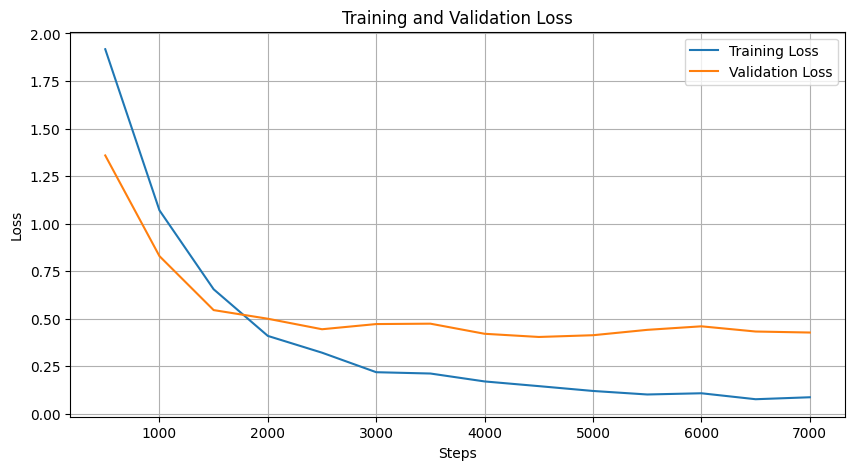

In [37]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

def plot_training_loss(log_dir):
    event_files = [os.path.join(log_dir, f) for f in os.listdir(log_dir) if 'events' in f]
    if not event_files:
        raise ValueError("No event files found in log directory.")

    for event_file in event_files:
        losses = {'Step': [], 'Training Loss': [], 'Validation Loss': []}
        for e in tf.compat.v1.train.summary_iterator(event_file):
            for v in e.summary.value:
                if v.tag == 'train/loss':
                    losses['Training Loss'].append(v.simple_value)
                    losses['Step'].append(e.step)
                elif v.tag == 'eval/loss':
                    losses['Validation Loss'].append(v.simple_value)

        if losses['Step']:
            df = pd.DataFrame(losses).set_index('Step')
            plt.figure(figsize=(10, 5))
            plt.plot(df['Training Loss'], label='Training Loss')
            plt.plot(df['Validation Loss'], label='Validation Loss')
            plt.xlabel('Steps')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()
            plt.grid(True)
            plt.show()

# 로그 디렉토리를 지정하여 그래프 그리기
plot_training_loss('./logs')

In [38]:
trainer.save_model('/content/drive/MyDrive/last_model/model_codebert(slice_safe)07-21')